# Exploration
Development playground

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 10

import Quandl
from n472jw.secrets import quandl_api_key
from n472jw.metrics import *

Populating the interactive namespace from numpy and matplotlib


# Utils

In [2]:
def rolling_apply(data, size, func):
    """multiple-column rolling window function as a generator"""
    n = len(data) - size + 1
    results = pd.DataFrame([func(data.iloc[i:i+size]) for i in range(n)])
    results.index = data.iloc[size-1:].index
    if len(results) == 0:
        results = pd.DataFrame(columns=['buy', 'stop', 'sell_by'])
    return results

def simulate(data, metric):
    #=====[ Step 1: get data and suggested results ]=====
    results = rolling_apply(data, metric.size, metric.ingest)
    data = pd.concat([data, results], axis=1)
    data['buy'] = data['buy'].fillna(False)
    
    #=====[ Step 2: evaluate ]=====
    profits = []
    for start_time, row in data[data.buy].iterrows():
        buy_price = row.Close
        end_time = row.sell_by
        hold_window = data[start_time:end_time]
        
        #####[ CASE: closed the gap ]#####
        if hold_window.High.max() > row.stop_above:
            sell_price = row.stop_above
            
        #####[ CASE: stop below ]#####
        elif hold_window.Low.min() < row.stop_below:
            sell_price = row.stop_below

        #####[ CASE: clock not run out yet ]#####
        elif end_time > data.index.max():
            sell_price = np.nan

        #####[ CASE: ran out the clock ]#####
        else:
            sell_price = data[:end_time].iloc[-1].Close

        profit = sell_price - buy_price
        profits.append({'date':start_time, 'profit':profit})
    profits = pd.DataFrame(profits)
    if len(profits) == 0:
        profits = pd.DataFrame(columns=['date', 'profit'])
    profits.index = profits.date
    return profits['profit']

# Perform Evaluation:

### Add sophistication:
- stop order below, percentage of stock size (limit losses)
- evaluate in terms of amount made, not total
- bound the size of the gap (relative to overall stock variance?)

In [3]:
#####[ PARAMS ]#####
date_start = pd.datetime(2015, 1, 1)
date_end = pd.datetime(2015, 12, 28)
all_tickers_csv = pd.read_csv('./data/WIKI-datasets-codes.csv', header=None)
all_tickers = list(all_tickers_csv[0].str.split('/').str.get(1))
####################

evaluation = pd.DataFrame(np.zeros((len(all_tickers), 4)))
evaluation.index = all_tickers
evaluation.columns = [10, 30, 60, 90]
                          
from tqdm import tqdm
from n472jw.metrics.gap_metrics import DownGapMetric
for ticker in tqdm(all_tickers):
    for num_days in [10, 30, 60, 90]:
        try:
            data = pd.read_pickle('./data/{}.pkl'.format(ticker))[date_start:date_end]
            metric = DownGapMetric(wait_period=pd.Timedelta('{} days'.format(num_days)))
            evaluation.loc[ticker][num_days] = simulate(data, metric).sum()
        except:
            continue

# Results:

In [4]:
df = evaluation.replace(0.0, np.inf)
ix = df.sum(axis=1) < np.inf
print '# of stocks with gaps: {}'.format(ix.sum())
(df[ix] > 0.001).mean(axis=0)


# of stocks with gaps: 873


10    0.545246
30    0.610538
60    0.634593
90    0.660939
dtype: float64

In [79]:
ix.iloc[:500]

A       False
AA      False
AAL      True
AAMC     True
AAN      True
AAOI    False
AAON    False
AAP      True
AAPL     True
AAT     False
AAWW    False
ABAX     True
ABBV     True
ABC     False
ABCB    False
ABCO     True
ABFS    False
ABG      True
ABM     False
ABMD     True
ABT      True
ACAD     True
ACAS    False
ACAT     True
ACC     False
ACCL    False
ACCO    False
ACE      True
ACET    False
ACFN    False
        ...  
CARA    False
CARB     True
CAS     False
CASH    False
CASS     True
CASY    False
CAT      True
CATM     True
CATO    False
CATY    False
CAVM     True
CB      False
CBB     False
CBEY    False
CBF     False
CBG      True
CBI     False
CBK      True
CBL     False
CBM     False
CBOE     True
CBPX     True
CBR     False
CBRL     True
CBS     False
CBSH    False
CBST    False
CBT     False
CBU     False
CBZ     False
dtype: bool

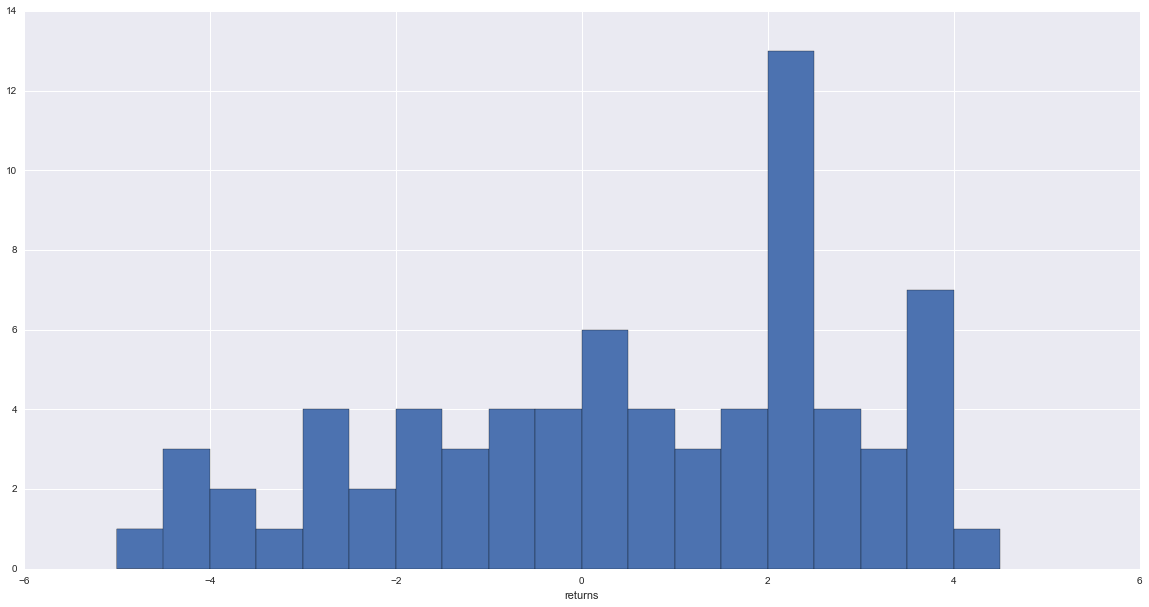

In [42]:
plt.hist(df[ix][50], bins=np.arange(-5, 5, 0.5))
plt.xlabel('returns')

In [136]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,buy,sell_by,stop,buy,sell_by,stop
Date,,,,,,,,,,,,,,,,,,
2015-01-02,27.86,28.12,27.38,27.61,22827200,0.19,1,27.425218,27.681160,26.952709,27.179119,22827200,False,NaT,NaN,False,NaT,NaN
2015-01-05,27.23,27.45,27.00,27.06,29306735,0.00,1,26.805049,27.021616,26.578639,26.637702,29306735,True,2015-03-06,27.38,False,2015-02-04,NaN
2015-01-06,27.12,27.68,27.04,27.05,47159620,0.00,1,26.696766,27.248027,26.618015,26.627859,47159620,True,2015-03-07,27.00,False,2015-02-05,NaN
2015-01-08,27.50,28.09,27.47,27.51,40789217,0.00,1,27.070836,27.651628,27.041304,27.080680,40789217,False,2015-03-09,NaN,False,2015-02-07,NaN
2015-01-12,28.00,28.20,27.82,28.05,38547403,0.00,1,27.563033,27.759912,27.385842,27.612253,38547403,True,2015-03-13,27.47,False,2015-02-11,NaN


In [133]:
results.head()

,buy,sell_by,stop
Date,,,
2015-01-05,False,2015-02-04,NaN
2015-01-06,False,2015-02-05,NaN
2015-01-08,False,2015-02-07,NaN
2015-01-12,False,2015-02-11,NaN
2015-01-13,False,2015-02-12,NaN


In [83]:
df['buy'] = df['buy'].fillna(False)

34

In [73]:
x[pd.datetime(2015, 11, 10):pd.datetime(2015, 11, 16)]

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,buy,stop
Date,,,,,,,,,,,,,,
2015-11-10,193.14,198.4500,189.550,196.99,4349892,0,1,193.14,198.4500,189.550,196.99,4349892,False,NaN
2015-11-11,198.20,202.9900,196.300,199.49,4528822,0,1,198.20,202.9900,196.300,199.49,4528822,False,NaN
2015-11-12,198.80,200.8611,197.540,198.14,3149997,0,1,198.80,200.8611,197.540,198.14,3149997,False,NaN
2015-11-13,195.61,197.1300,192.845,193.95,4056779,0,1,195.61,197.1300,192.845,193.95,4056779,True,197.54
2015-11-16,192.04,201.2400,191.000,198.72,4186320,0,1,192.04,201.2400,191.000,198.72,4186320,False,NaN


In [69]:
pd.concat([data.head(), r.head()], axis=1)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,buy,stop
Date,,,,,,,,,,,,,,
2015-01-02,229.46,230.45,221.4900,223.080,3473537,0,1,229.46,230.45,221.4900,223.080,3473537,NaN,NaN
2015-01-05,223.00,224.83,218.3501,219.785,2745154,0,1,223.00,224.83,218.3501,219.785,2745154,False,NaN
2015-01-06,220.89,222.87,216.0200,220.180,3220571,0,1,220.89,222.87,216.0200,220.180,3220571,False,NaN
2015-01-08,227.05,232.14,224.7300,229.210,2631276,0,1,227.05,232.14,224.7300,229.210,2631276,False,NaN
2015-01-12,226.10,226.50,220.0000,220.890,3160384,0,1,226.10,226.50,220.0000,220.890,3160384,False,NaN
2015-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


# Metrics Visualization

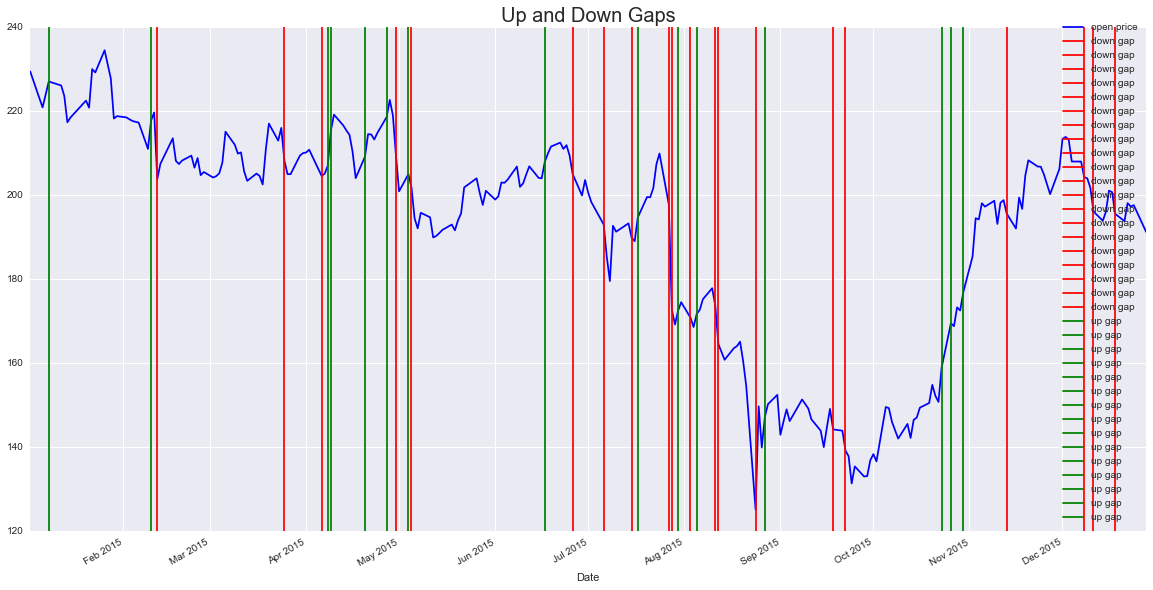

In [13]:
gaps_metric = GapsGetFilled(up_threshold=0.3, down_threshold=0.3)
gaps_metric.ingest(data)
gaps_metric.plot()

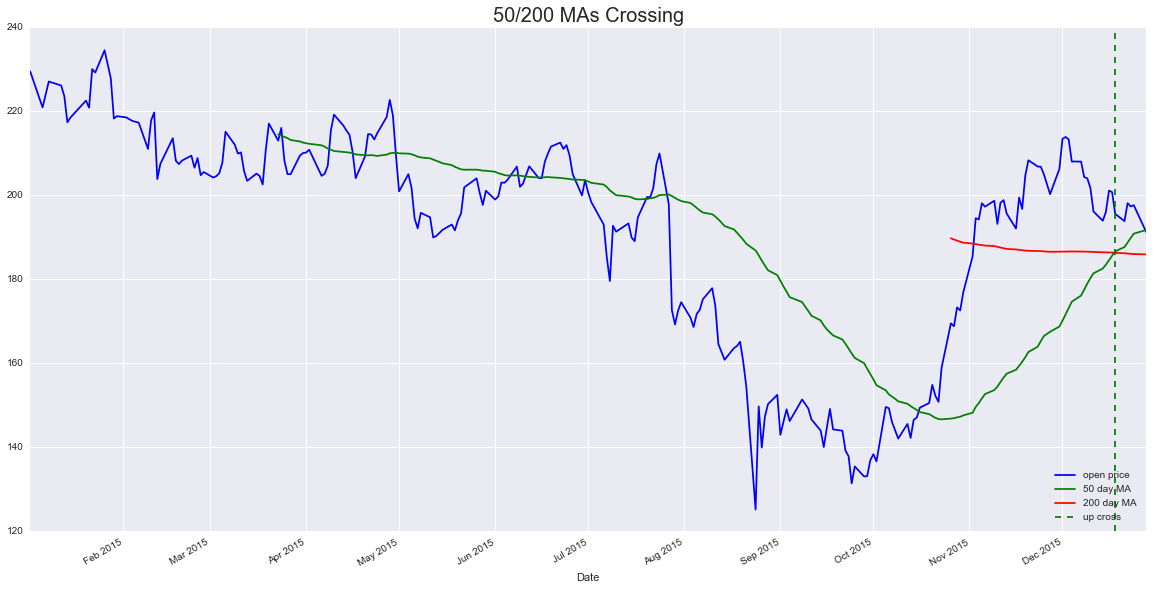

In [14]:
mas_metric = CrossingMovingAverages(ma1=50, ma2=200)
mas_metric.plot(data)

# Metric Evaluation: Gaps Get Filled
- Run the metric
- find periods of a certain length afterwards...
- each metric has it's own evaluation method though... should have a "buy at" and a "sell at"

In [153]:
#####[ PARAMS ]#####
metric = gaps_metric
hold_period = pd.Timedelta('60 days')
####################

#=====[ Step 1: get buy/sell dfs ]=====
buy_series, sell_series = metric.transform(data)

#=====[ Step 2: cut out periods afterwards ]=====
print '=====[ Buy Dates (down gap) ]====='
print 'Buy Date | Price Change over {}'.format(hold_period)
for date, val in buy_series.iterrows():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    reaches_goal = df.High.max() >= val.down_gap_sell_price
    if reaches_goal:
        change = df.High.max() - df.iloc[0].Close 
    else:
        change = df.iloc[-1].Close - df.iloc[0].Close
    print date, reaches_goal, change

print 
    
print '=====[ Sell Dates (up gap) ]====='
print 'Sell Date | Price Change over {}'.format(hold_period)
for date, val in sell_series.iterrows():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    reaches_goal = df.Low.min() <= val.up_gap_buy_price

    if reaches_goal:
        change = df.Low.min() - df.iloc[0].Open 
    else:
        change = df.iloc[-1].Close - df.iloc[0].Open
    print date, reaches_goal, change    

=====[ Buy Dates (down gap) ]=====
Buy Date | Price Change over 60 days 00:00:00
2013-02-05 00:00:00 False -12.78
2013-02-19 00:00:00 False -5.75
2013-04-05 00:00:00 True 17.09
2013-04-26 00:00:00 True 18.59
2013-06-24 00:00:00 True 53.23
2014-01-23 00:00:00 True 25.76
2014-08-28 00:00:00 True 17.6
2014-12-01 00:00:00 False -18.69
2015-02-12 00:00:00 True 15.73
2015-03-25 00:00:00 True 16.21
2015-04-06 00:00:00 True 20.35
2015-04-30 00:00:00 False -1.2
2015-05-05 00:00:00 True 19.48
2015-06-26 00:00:00 True 6.64
2015-07-06 00:00:00 True 20.97
2015-07-15 00:00:00 True 23.42
2015-07-27 00:00:00 False -63.305
2015-07-28 00:00:00 False -33.645
2015-08-03 00:00:00 True 9.92
2015-08-11 00:00:00 False -23.72
2015-08-12 00:00:00 True 7.69
2015-08-24 00:00:00 True 18.48
2015-09-18 00:00:00 True 62.25
2015-09-22 00:00:00 True 74.78
2015-11-13 00:00:00 True 24.02
2015-12-08 00:00:00 False -12.22
2015-12-11 00:00:00 True 7.62
2015-12-18 00:00:00 True 6.77

=====[ Sell Dates (up gap) ]=====
Sell Da

# Metric Evaluation: Crossing Moving Averages

In [16]:
#####[ PARAMS ]#####
metric = mas_metric
hold_period = pd.Timedelta('30 days')
####################

#=====[ Step 1: get buy/sell dfs ]=====
buy_series, sell_series = metric.transform(data)

#=====[ Step 2: cut out periods afterwards ]=====
print '=====[ Buy Dates (MA1 Crosses Over MA2)  ]====='
print 'Buy Date | Success | Price Change over {}'.format(hold_period)
for date, val in buy_series.iteritems():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    change = df.iloc[-1].Close - df.iloc[0].Open
    success = change > 0
    print date, success, change

print '=====[ Sell Dates (MA1 Crossed Under MA2) ]====='
print 'Sell Date | Success | Price Change over {}'.format(hold_period)
for date, val in sell_series.iteritems():
    # TODO: check for end condition here #
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    change = df.iloc[-1].Close - df.iloc[0].Open
    success = change < 0
    print date, success, change

=====[ Buy Dates (MA1 Crosses Over MA2)  ]=====
Buy Date | Success | Price Change over 30 days 00:00:00
2015-12-18 00:00:00 False -2.74
=====[ Sell Dates (MA1 Crossed Under MA2) ]=====
Sell Date | Success | Price Change over 30 days 00:00:00
